In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kelixirr/pizza-steak-image-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1


In [2]:
import os
print(os.listdir("/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak"))
print(os.listdir("/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak/train"))
print(os.listdir("/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak/train/pizza"))

['train', 'test']
['steak', 'pizza']
['2800325.jpg', '1055065.jpg', '3425999.jpg', '1947572.jpg', '1008941.jpg', '829229.jpg', '1054420.jpg', '413710.jpg', '3826377.jpg', '143453.jpg', '809024.jpg', '3324050.jpg', '448519.jpg', '1008104.jpg', '2274117.jpg', '1571074.jpg', '2331467.jpg', '1980167.jpg', '98617.jpg', '3702863.jpg', '674188.jpg', '3193599.jpg', '3214153.jpg', '2486277.jpg', '238843.jpg', '3082443.jpg', '2231356.jpg', '2793535.jpg', '3164761.jpg', '740385.jpg', '3749515.jpg', '495892.jpg', '2021516.jpg', '596494.jpg', '676432.jpg', '384215.jpg', '422261.jpg', '3191035.jpg', '3342039.jpg', '1877103.jpg', '878377.jpg', '2236914.jpg', '3772054.jpg', '2501636.jpg', '1608000.jpg', '2462190.jpg', '2097315.jpg', '1544197.jpg', '1577871.jpg', '618021.jpg', '2811032.jpg', '3168266.jpg', '1870865.jpg', '1584379.jpg', '917774.jpg', '233143.jpg', '175626.jpg', '762788.jpg', '979998.jpg', '403431.jpg', '967694.jpg', '899959.jpg', '2126709.jpg', '1670471.jpg', '2990023.jpg', '1761451.jpg

Image shape: (384, 512, 3)


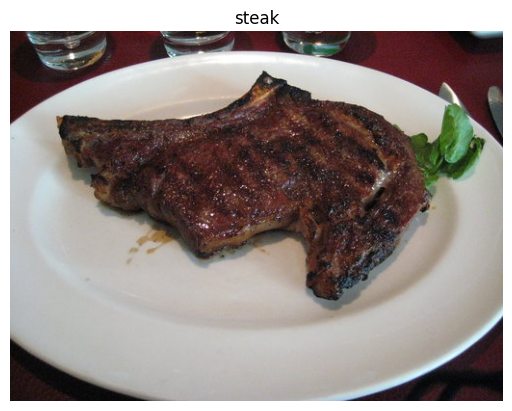

In [3]:
import os
import random  # Add this line to import the 'random' module
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = os.path.join(target_dir, target_class)

    # Get a random image path
    random_image = random.choice(os.listdir(target_folder))

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(os.path.join(target_folder, random_image))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    # Show the shape of the image
    print(f"Image shape: {img.shape}")  

    return img

img = view_random_image("/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak/train","steak")

In [4]:
# PyTorch equivalent of Keras model, data loading, training, and evaluation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Data preprocessing (scaling and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Keras rescales to [0,1], ToTensor() does this automatically
])

# Directories
train_dir = "/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak/train/"
test_dir = "/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak/test/"

# Data generators (PyTorch DataLoader)
batch_size = 32
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv4 = nn.Conv2d(10, 10, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        # Dynamically compute the number of features
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(dummy)))))
            x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
            n_features = x.numel()
        self.fc = nn.Linear(n_features, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = torch.sigmoid(self.fc(x))
        return x

# Instantiate model, loss, optimizer
model = CNNModel()
criterion = nn.BCELoss()  # Use BCELoss since output is sigmoid
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        labels = labels.float().unsqueeze(1)  # Make sure labels are float and shape (batch, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"           Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

Epoch 1/15 - Train loss: 0.6223, Train acc: 0.6380
           Val loss: 0.4338, Val acc: 0.8260
Epoch 2/15 - Train loss: 0.4805, Train acc: 0.7787
           Val loss: 0.3826, Val acc: 0.8420
Epoch 3/15 - Train loss: 0.4506, Train acc: 0.8033
           Val loss: 0.3833, Val acc: 0.8480
Epoch 4/15 - Train loss: 0.4714, Train acc: 0.7953
           Val loss: 0.3809, Val acc: 0.8480
Epoch 5/15 - Train loss: 0.4104, Train acc: 0.8193
           Val loss: 0.3395, Val acc: 0.8740
Epoch 6/15 - Train loss: 0.3967, Train acc: 0.8327
           Val loss: 0.3512, Val acc: 0.8420
Epoch 7/15 - Train loss: 0.3886, Train acc: 0.8407
           Val loss: 0.3501, Val acc: 0.8540
Epoch 8/15 - Train loss: 0.3822, Train acc: 0.8473
           Val loss: 0.3401, Val acc: 0.8520


KeyboardInterrupt: 

In [5]:
# Get the class names programmatically
import pathlib
import numpy as np
#turn our training path into a python path
data_dir= pathlib.Path('/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak/train')
#created a classnames from the subdirectories
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


In [6]:
#preprocess and expand dims in same function
from PIL import Image
import torch
from torchvision import transforms

def load_and_prep_image_pt(filename, img_shape=224, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize((img_shape, img_shape)),
        transforms.ToTensor(),
    ])
    img = Image.open(filename).convert('RGB')
    img_tensor = transform(img)
    print(f"Shape before new dimension: {img_tensor.shape}")  # (3, 224, 224)
    img_tensor = img_tensor.unsqueeze(0)
    print(f"Shape after new dimension: {img_tensor.shape}")   # (1, 3, 224, 224)
    img_tensor = img_tensor.to(device)
    return img_tensor

In [7]:
steak=load_and_prep_image_pt('/home/wanglab/.cache/kagglehub/datasets/mostafizur1997/steak-image/versions/1/steak.jpeg')

Shape before new dimension: torch.Size([3, 224, 224])
Shape after new dimension: torch.Size([1, 3, 224, 224])


In [8]:
pred = model(steak)
pred

tensor([[0.8073]], grad_fn=<SigmoidBackward0>)

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

def load_and_prep_image_pt(filename, img_shape=224, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize((img_shape, img_shape)),
        transforms.ToTensor(),
    ])
    img = Image.open(filename).convert('RGB')
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    return img_tensor, img  # Return both tensor and PIL image for plotting

def pred_and_plot_pt(model, filename, class_names, device='cpu'):
    model.eval()
    img_tensor, img_pil = load_and_prep_image_pt(filename, device=device)
    with torch.no_grad():
        pred = model(img_tensor)
        pred_class = class_names[int(torch.round(pred)[0][0].cpu())]
    plt.imshow(img_pil)
    plt.title(f"Prediction: {pred_class}")
    plt.axis('off')
    plt.show()

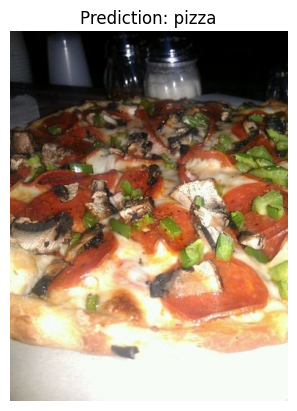

In [10]:
pred_and_plot_pt(model, '/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak/test/pizza/1180001.jpg', class_names )

In [23]:
# Print class order and prediction value for debugging
print("PyTorch class_names:", class_names)
img_tensor, img_pil = load_and_prep_image_pt('/home/wanglab/.cache/kagglehub/datasets/kelixirr/pizza-steak-image-classification-dataset/versions/1/pizza_steak/test/pizza/1180001.jpg')
model.eval()
with torch.no_grad():
    pred = model(img_tensor)
    print("Raw prediction value:", pred.item())
    print("Predicted class index:", int(torch.round(pred)[0][0].cpu()))
    print("Predicted class name:", class_names[int(torch.round(pred)[0][0].cpu())])

PyTorch class_names: ['pizza' 'steak']
Raw prediction value: 0.5287091732025146
Predicted class index: 1
Predicted class name: steak
